# Linear Bidding

In [5]:
#packages import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.utils import resample
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pickle

In [44]:
# load information learned from the Feature Engineering file
filename = 'Lin_model.sav'
lin_model = pickle.load(open(filename, 'rb'))
print(lin_model)

features = 'features.pkl'
features = pickle.load(open(features, 'rb'))
print(features)

#constant value between both datasets; based on the training dataset
avgCTR = 0.0007375623256619447

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
['click', 'adexchange', 'useragent_android_safari', 'useragent_windows_chrome', 'useragent_windows_firefox', 'useragent_windows_ie', 'slotvisibility_0', 'slotvisibility_1', 'slotvisibility_2', 'slotvisibility_Na', 'slotvisibility_OtherView', 'slotformat_0', 'slotformat_1', 'slotformat_Na', 'keypage_361e128affece850342293213691a043', 'keypage_d29e59bf0f7f8243858b8183f14d4412', 'slotsize_1000x90', 'slotsize_250x250', 'slotsize_320x50', 'slotsize_950x90']


In [15]:
#dataset import
validation_data = pd.read_csv("validation.csv")

validation_data['adexchange'] = validation_data['adexchange'].fillna(0)
validation_data['slotsize'] = validation_data['slotwidth'].astype(str) + 'x' + validation_data['slotheight'].astype(str)
validation_data.head(3)

cat_col = ['useragent','slotvisibility', 'slotformat', 'keypage', 'slotsize']

validation_data = pd.get_dummies(validation_data, columns=cat_col, prefix=cat_col)

In [23]:
valid_X = validation_data[features]
valid_y = validation_data[['click','bidprice', 'payprice']]

In [91]:
# valid_pred_CTR2 = lin_model.predict_proba(valid_X)
# unique_elements, counts_elements = np.unique(valid_pred_CTR, return_counts=True)
# print("Frequency of unique values:")
# print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values:
[[     0      1]
 [303723    202]]


In [27]:
def performance(bids, true, budget=6250*1000, verbose=True):

    CTR = 0
    num_clicks = 0
    spend = 0

    #--- Combine data in to one dataframe ------
    df = true.copy()
    df['bid'] = bids

    #--- Work out which bids were successful ---
    #> if they are greater than payprice
    success_bids = df[df.bid > df.payprice]



    #--- Only keep bids that are within budget -
    total_spend = np.cumsum(np.array(success_bids.payprice))

    x=0
    if len(total_spend)>0:
        x = np.argmax(total_spend > budget)

    if x>0:
        # then at some point bids went over budget
        in_budget_bids = success_bids[0:x-1]

    else:
        in_budget_bids = success_bids

    spend = in_budget_bids.payprice.sum()


    #--- Find out which bids were clicked ------
    clicked_bids = in_budget_bids[in_budget_bids.click==1]

    num_clicks = len(clicked_bids.payprice)

    #--- click through rate -------
    CTR = num_clicks/len(success_bids) if len(success_bids) > 0 else None




    return CTR, num_clicks, spend

In [ ]:
#other teams approach!!!!
    '''
    used the performance() function
    valid_pred_CTR = lin_model.predict(valid_X) <= where the pCTR is the predicted value
    '''

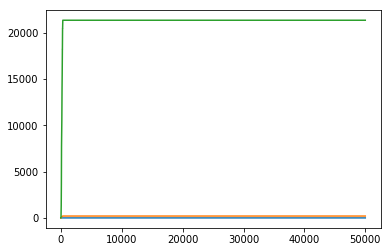

In [93]:
valid_pred_CTR = lin_model.predict(valid_X)
min_base_bid = 0
max_base_bid = 5e4
n_base_bids = 10000

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)
CTR_list = []

for i, bb in zip(range(n_base_bids), base_bid):
    bids = bb*valid_pred_CTR
    CTR = performance(bids, valid_y, verbose=False)
    CTR_list.append(CTR)
    clicks[i] = c
    
plt.plot(base_bid, CTR_list)
plt.show()

In [ ]:
#OUR APPROACH
    '''
    used the lin_bid() function
    valid_pred_CTR2 = lin_model.predict_proba(valid_X) <= where the pCTR is the 'predict_proba' value
    '''

In [100]:
#bid = base bid×pCTR/avgCTR
def lin_bid(data, df, base_bid, budget = 6250000):
   
    counter = 0
    get_bid = []
    while ((budget >= 0) & (counter < len(data))):
        pCTR_list = lin_model.predict_proba(data.iloc[[counter]])
        pCTR = [item[1] for item in pCTR_list][0]
        
        bid = base_bid * pCTR /avgCTR
        
        if(df['payprice'][counter] <= bid):
            budget -= df['payprice'][counter]
            get_bid.append(df['click'][counter])
        counter += 1
    return get_bid.count(1)

In [ ]:
min_base_bid = 0
max_base_bid = 300
n_base_bids = 10000

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)
CTR_list = []

for bb in range(min_base_bid,max_base_bid, 50):
    #bids = bb*valid_pred_CTR2  
    
    print(bb)
    CTR = lin_bid(valid_X, valid_y, bb)
    CTR_list.append(CTR)
    #clicks[i] = c

print(CTR_list)    
plt.plot(base_bid, CTR_list)
plt.show()

0


In [ ]:
min_base_bid = 0
max_base_bid = 300
n_base_bids = 10000

base_bid = np.linspace(min_base_bid, max_base_bid, n_base_bids)
clicks = np.zeros_like(base_bid)
CTR_list = []

for bb in range(min_base_bid,max_base_bid, 10):
    #bids = bb*valid_pred_CTR2/avgCTR  
    #print(np.unique(bids))
    CTR = lin_bid(bb, valid_y)
    print(bb, CTR)
    CTR_list.append(CTR)
    #clicks[i] = c

print(CTR_list)    
plt.plot(base_bid, CTR_list)
plt.show()